In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl

sys.path.append(r"/ssd_scratch/scripts/sdtools")

from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *

%load_ext autoreload
%autoreload 2

/ssd_scratch/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Make new grid file, any previous grids with same name are overwritten

In [2]:
# Ensure you don't have a mesh file already loaded (netCDF caching is problematic)
try:
    mesh.close()
    del mesh
except:
    pass

# Create new grid from an existing one, read it in and create the Field object
shutil.copy(r"/ssd_scratch/hcases/g3b1-lores_newhypno.nc", r"/ssd_scratch/hcases/g3b1f3-only_pump.nc")


'/ssd_scratch/hcases/g3b1f3-only_pump.nc'

# Put in the is_pump field and close the grid
- It's critical to close the mesh afterwards
- Otherwise you get random numbers in the grid

Mesh file /ssd_scratch/hcases/g3b1f3-only_pump.nc closed


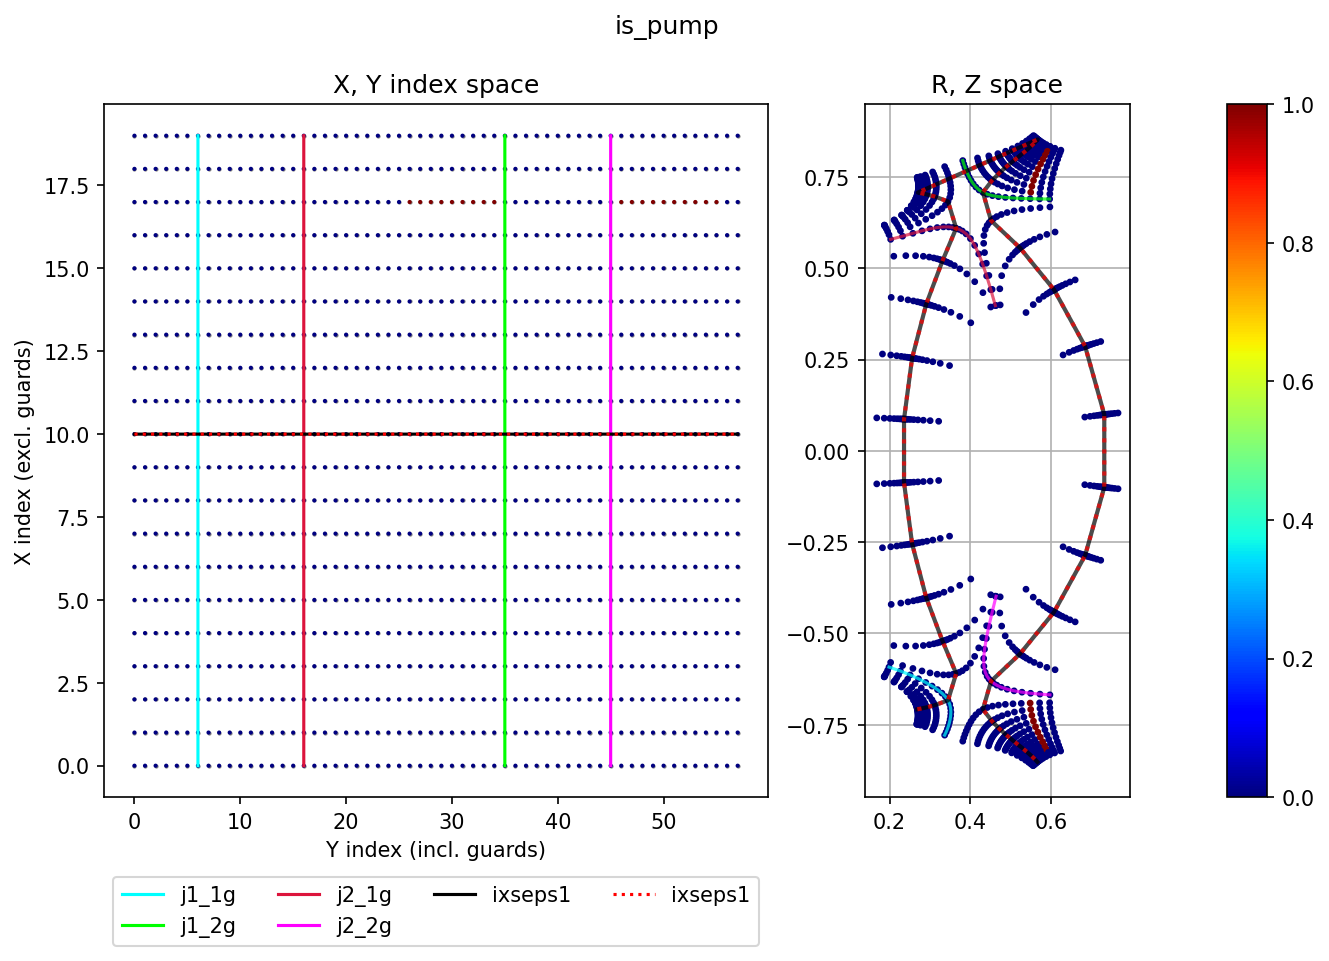

In [5]:
mesh = Mesh(r"/ssd_scratch/hcases/g3b1f3-only_pump.nc")
plt.close("all")

is_pump = Field("is_pump", mesh)
# is_pump.data[:,:] = 10

# is_pump.set_value([slice(None,None), slice(None,None)], 0, make_per_volume = False)
is_pump.data[ (-3, np.r_[
    slice((-mesh.MYG-10),-mesh.MYG), 
    slice(mesh.ny_inner + mesh.MYG*3,mesh.ny_inner + mesh.MYG*3 + 9 )
             ]) ] = 1.0

is_pump.plot(dpi = 150)

mesh.mesh.write("is_pump", is_pump.data, info = True)
mesh.close()

# mesh.write_field(is_pump, dtype = "Field2D")
# mesh.write_field(D_i, dtype = "Field2D")
# mesh.write_field(Chi_e, dtype = "Field2D")
# mesh.write_field(Chi_i, dtype = "Field2D")

# Check if it's correct and close it again

Mesh file /ssd_scratch/hcases/g3b1f3-only_pump.nc closed


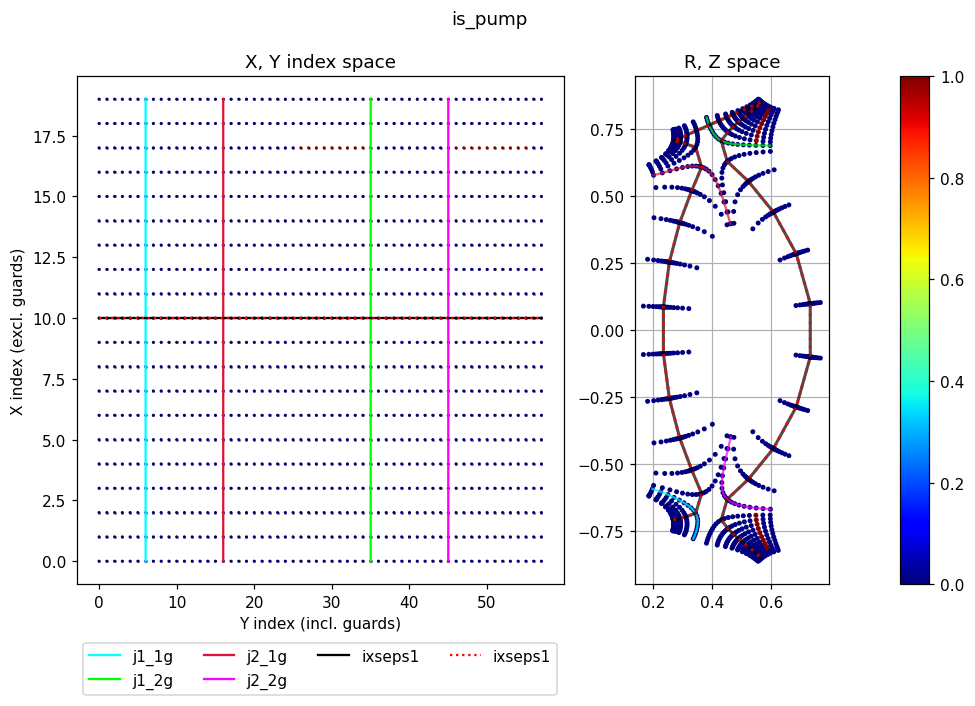

In [2]:
mesh = Mesh(r"/ssd_scratch/hcases/g3b1f3-only_pump.nc")
mesh.plot_field("is_pump")
mesh.close()

# Check results

--> dx, dy and J will not be unnormalised
CHECK: Total domain volume is 1.607E+00 [m3]
--> dx, dy and J will not be unnormalised
CHECK: Total domain volume is 1.032E+00 [m3]


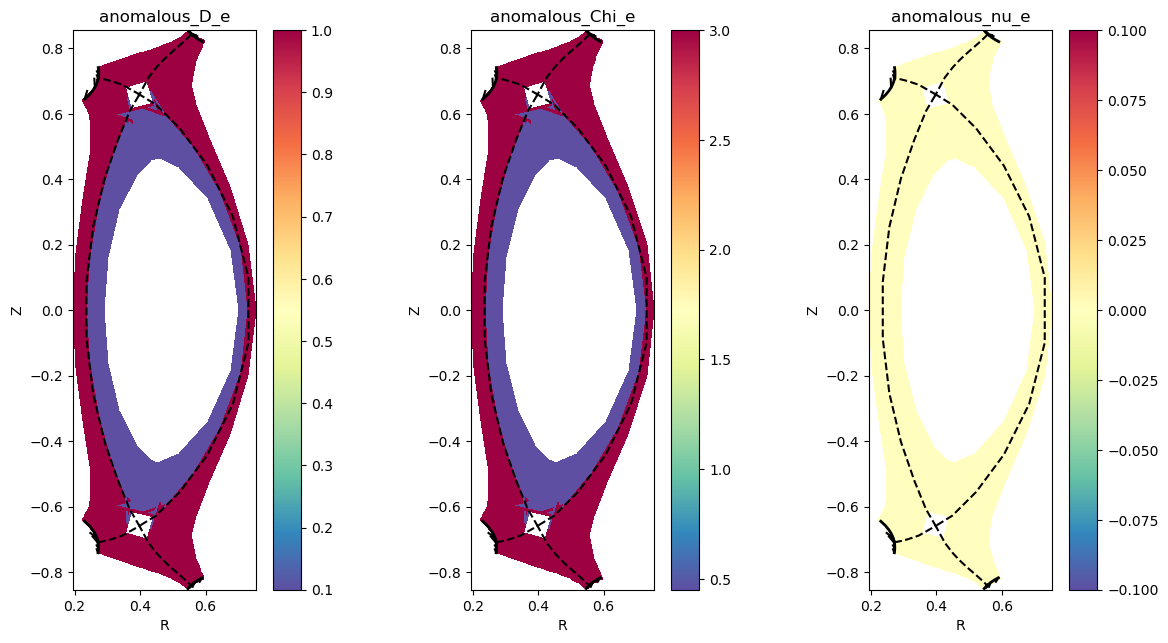

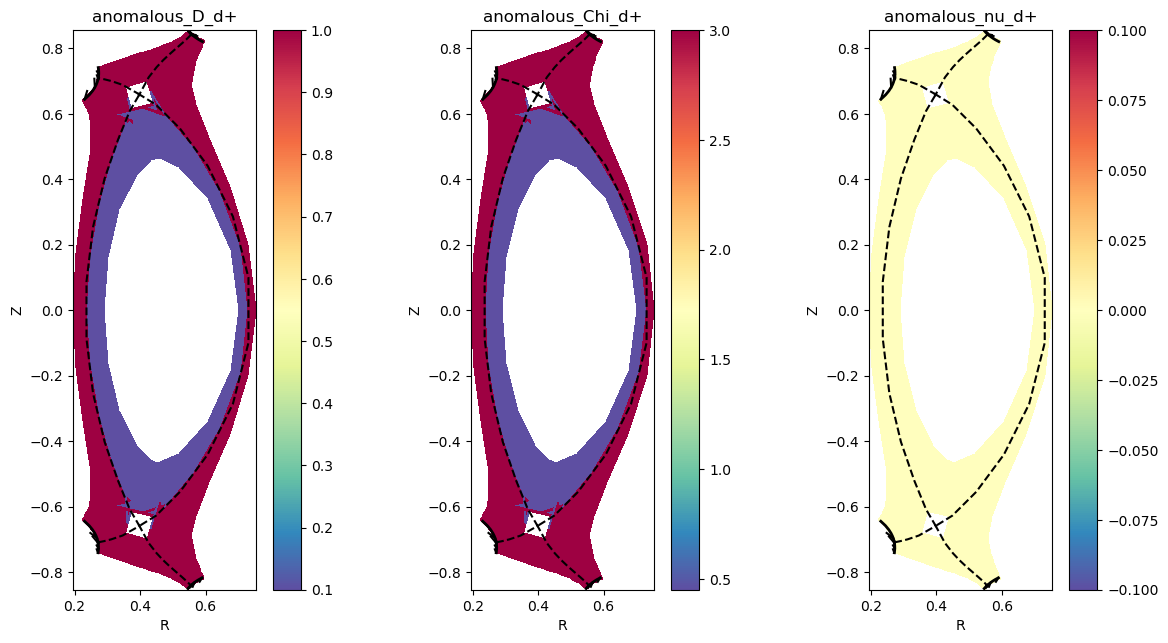

In [5]:
db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

choice = "b1-jan23base"

case, caseng = Load.case_2D(db.casepaths[choice], gridfilepath = db.gridpaths["g3a4-lores.nc"],
                    double_load = True)

data = caseng.ds

cols = 3
tind = -1

for x in ["e", "d+"]:
    fig, axes = plt.subplots(1,cols, figsize = (cols*4,6), dpi = 100)
    fig.tight_layout(pad = 0.4)
    data[f"anomalous_D_{x}"].isel(t=tind).bout.pcolormesh(ax = axes[0], cmap = "Spectral_r", logscale = False)
    data[f"anomalous_Chi_{x}"].isel(t=tind).bout.pcolormesh(ax = axes[1], cmap = "Spectral_r", logscale = False)
    data[f"anomalous_nu_{x}"].isel(t=tind).bout.pcolormesh(ax = axes[2], cmap = "Spectral_r", logscale = False)

# Puff implementation

In [ ]:
total_flow = 1.2e21 * 0.1 # atoms per second

# Get volume of region and calculate source
volume = case.select_symmetric_puff(width=3, center_half_gap=1)["dv"]
source = total_flow / volume

# Create new grid from an existing one, read it in and create the Field object
shutil.copy(r"/ssd_scratch/hcases/g3a4-lores.nc", r"/ssd_scratch/hcases/g3a4x1-puff1.nc")
mesh = Mesh(r"/ssd_scratch/hcases/g3a4x1-puff1.nc")
puff = Field("Nd_src", mesh)

# Set puff cells to the calculated source
# Selector slice references puff location
selector = mesh.slices("symmetric_puff")(width=3, center_half_gap=1)
puff.data[selector] = source.values

# Plot to check values
# puff.plot()

# mesh.write_field(puff)

In [ ]:
mesh.write_field(puff)
mesh.close()
del mesh

Defining dimension z of size 1
>>> Field Nd_src already exists in /ssd_scratch/hcases/g3a4x1-puff1.nc, it will be overwritten
-> Wrote field Nd_src to /ssd_scratch/hcases/g3a4x1-puff1.nc
Mesh file /ssd_scratch/hcases/g3a4x1-puff1.nc closed


In [ ]:
mesh = Mesh(r"/ssd_scratch/hcases/g3a4x1-puff1.nc")
# mesh.keys()

In [ ]:
set(mesh.mesh["Nd_src"].flatten())

{0.0,
 1.6755428055240319e+22,
 1.6755428055241296e+22,
 1.7589932041422974e+22,
 1.7589932041423766e+22,
 1.9651548595625874e+22,
 1.965154859562611e+22}